## Setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import os.path as op
import math
from sklearn.model_selection import train_test_split
import numpy.ma as ma
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer

In [3]:
# Read test_df, train_df

# Colab only gives temporary storage, need to upload the file every time
dir_path = "/content/sample_data"
# loan_sanction_test.csv doesn't have labels, so split train.csv to be train and test
dataset_path = op.join(dir_path, "loan_sanction_train.csv")
df = pd.read_csv(dataset_path, header=0)
train_df, test_df = train_test_split(df, test_size=0.2)

In [4]:
def get_labels_features(df):
  # convert non numerical variables to nums, so can be used for calculation
  df['Gender_num'] = df['Gender'].map({'Female':1, 'Male':-1, np.NaN:0}).astype(int)
  df['Married_num'] = df['Married'].map({'Yes':1, 'No':-1, np.NaN:0}).astype(int)
  df['Dependents_num'] = df['Dependents'].map({'3+':3, '2':2, '1':1, '0':0, np.NaN:-1}).astype(int)
  df['Education_num'] = df['Education'].map({'Graduate':1, 'Not Graduate':-1, np.NaN:0}).astype(int)
  df['Self_Employed_num'] = df['Self_Employed'].map({'Yes':1, 'No':-1, np.NaN:0}).astype(int)
  df['Property_Area_num'] = df['Property_Area'].map({'Urban':1, 'Rural':-1, 'Semiurban':0}).astype(int)
  df['Loan_Status_num'] = df['Loan_Status'].map({'Y':1, 'N':-1}).astype(int)

  # If one element of a numerical field is empty, assume it to be the median of that field
  for num_var in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']:
    var_median = df[num_var].dropna().median()
    if len(df[num_var][df[num_var].isnull()]) > 0:
      df.loc[(df[num_var].isnull()), num_var] = var_median
  
  # Incomes can vary a lot, use log
  # use masked array to avoid doing doing log for zeros
  col = df['ApplicantIncome']
  df['ApplicantIncome_lg'] = np.log(col, out=np.zeros_like(col), where=(col != 0))
  col = df['CoapplicantIncome']
  df['CoapplicantIncome_lg'] = np.log(col, out=np.zeros_like(col), where=(col != 0))

  # extract y (label)
  y = df['Loan_Status_num'].to_numpy()

  # extract X (features)
  features = df[[
      'Gender_num', 
      'Married_num', 
      'Dependents_num', 
      'Education_num', 
      'Self_Employed_num', 
      'ApplicantIncome_lg', 
      'CoapplicantIncome_lg', 
      'LoanAmount', 
      'Loan_Amount_Term', 
      'Credit_History', 
      'Property_Area_num', 
  ]]
  X = features.to_numpy()

  return y, X

In [5]:
train_y, train_X = get_labels_features(train_df)
test_y, test_X = get_labels_features(test_df)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Propocessing Data

In [6]:
# Detect outliers
def get_outliers(data, columns, nsd=7):
    outlier_idxs = []
    for col in columns:
        elements = data[col]
        mean = elements.mean()
        sd = elements.std()
        # get the index values of all values higher or lower than the mean +/- nsd standard deviations
        outliers_mask = data[(data[col] > mean + nsd*sd) | (data[col]  < mean  - nsd*sd)].index
        # add those index values to our list
        outlier_idxs  += [x for x in outliers_mask]
    return list(set(outlier_idxs))

# assign data type and NA values, also check with outliers
def prepro(df,numimp,catimp):
      # drop ID column
      df=df.drop(['Loan_ID'],axis=1)

      # identify numeric/categorical features
      numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
      categorical_features = df.select_dtypes(include=['object', 'category']).drop(['Loan_Status'], axis=1).columns

      # Credit_History should be a categorical variable
      numeric_features=numeric_features.drop('Credit_History')
      categorical_features=categorical_features.insert(6, 'Credit_History') 
    
      # assign datatypes
      for col in categorical_features.tolist():
              df[col] = df[col].astype('category')

      df['Loan_Status'] = df['Loan_Status'].astype('category')   

      #identify and remove outliers for the numerical variables
      outs = get_outliers(df, numeric_features)
      df = df.drop(outs, axis = 0)

      # impute missing numerical values
      imputer = SimpleImputer(missing_values = np.nan, strategy = numimp)
      imputer = imputer.fit(df[numeric_features.tolist()])
      df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])

      #impute missing categorical values. 
      imputercat = SimpleImputer(missing_values = np.nan, strategy = catimp)
      imputercat = imputercat.fit(df[categorical_features.tolist()])
      df[categorical_features.tolist()] = imputercat.transform(df[categorical_features.tolist()])
      df['Credit_History'] = df['Credit_History'].astype('category')   

      # features
      feat = df.loc[:, df.columns != 'Loan_Status']

      # label
      lab = df.Loan_Status

      # hot encode the categorical features
      feat = pd.get_dummies(feat)

      # re-code the response variable
      repmap={"Y": 1, "N": 0}
      lab.replace(repmap, inplace=True)

      # log transforation to househode income
      feat['Household_Income_log']=np.log(feat.ApplicantIncome + feat.CoapplicantIncome)

      # Append new feature to our numerical features
      numeric_features=numeric_features.insert(len(numeric_features),'Household_Income_log') 
      
      # Return the features (feat) and labels (lab)
      return feat, lab, numeric_features

In [7]:
# Call PREPROCESSING function and pass it the dataframe as well as the imputation strategies for (1) numerical and (2) categorical features
data = prepro(df,'median','most_frequent') 

# Separate features (X) and labels (y) from data object
X=data[0]
y=data[1]

# Get numerical features
numeric_features = data[2]

# Verify that it worked
display(X.head())
display(y.head())
display(numeric_features)
display(f"Observations after Preprocessing: {len(X)}")

# check missing values
print(df.isnull().sum())

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Household_Income_log
0,5849.0,0.0,127.0,360.0,0,1,1,0,1,0,...,1,0,1,0,0,1,0,0,1,8.674026
1,4583.0,1508.0,128.0,360.0,0,1,0,1,0,1,...,1,0,1,0,0,1,1,0,0,8.714568
2,3000.0,0.0,66.0,360.0,0,1,0,1,1,0,...,1,0,0,1,0,1,0,0,1,8.006368
3,2583.0,2358.0,120.0,360.0,0,1,0,1,1,0,...,0,1,1,0,0,1,0,0,1,8.505323
4,6000.0,0.0,141.0,360.0,0,1,1,0,1,0,...,1,0,1,0,0,1,0,0,1,8.699515


0    1
1    0
2    1
3    1
4    1
Name: Loan_Status, dtype: category
Categories (2, int64): [0, 1]

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Household_Income_log'],
      dtype='object')

'Observations after Preprocessing: 609'

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


                            OLS Regression Results                            
Dep. Variable:            Loan_Status   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     11.48
Date:                Sun, 07 May 2023   Prob (F-statistic):           1.49e-23
Time:                        18:14:15   Log-Likelihood:                -201.21
No. Observations:                 426   AIC:                             434.4
Df Residuals:                     410   BIC:                             499.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Text(113.9222222222222, 0.5, 'Actual label')

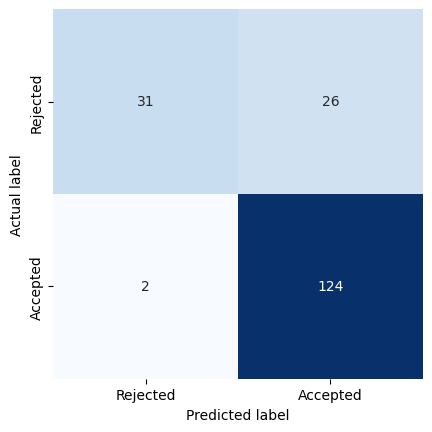

In [8]:
# Import necessary packages
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X = sm.add_constant(X) # adding a constant
 
# Fit the model on the training set
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

print_model = model.summary()
print(print_model)


# Make predictions on the test set
X_test = sm.add_constant(X_test)
predictions = model.predict(X_test) > 0.5

# Calculate the test MSE
test_mse = mean_squared_error(y_test, predictions)

# Print the test MSE
print("Test MSE: {:.2f}".format(test_mse))

# Compute confusion matrix
mat = confusion_matrix(y_test, predictions)
labels = ['Rejected', 'Accepted']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')


In [9]:
# Calculate accuracy
from sklearn import metrics

print("OLS")
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))

OLS
Accuracy: 0.8469945355191257
Precision: 0.8266666666666667
Recall: 0.9841269841269841


## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [11]:
def get_sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [12]:
# Train the model

logistic_regression = LogisticRegression(
    # Smaller C specifies Stronger regularization
    C=0.1,
    # max random seed is 42
    random_state=42, 
    # liblinear is best for binary cases
    solver="liblinear", 
    # default 100 max_iter may be too small
    max_iter=5000
)

logistic_regression.fit(train_X, train_y)

LogisticRegression(C=0.1, max_iter=5000, random_state=42, solver='liblinear')

In [13]:
# Test the model

predictions = logistic_regression.predict(test_X)
score = logistic_regression.score(test_X, test_y)
print(f"Accuracy = {score}")

Accuracy = 0.7723577235772358


Text(0.5, 1.0, 'Accuracy Score: 0.7723577235772358')

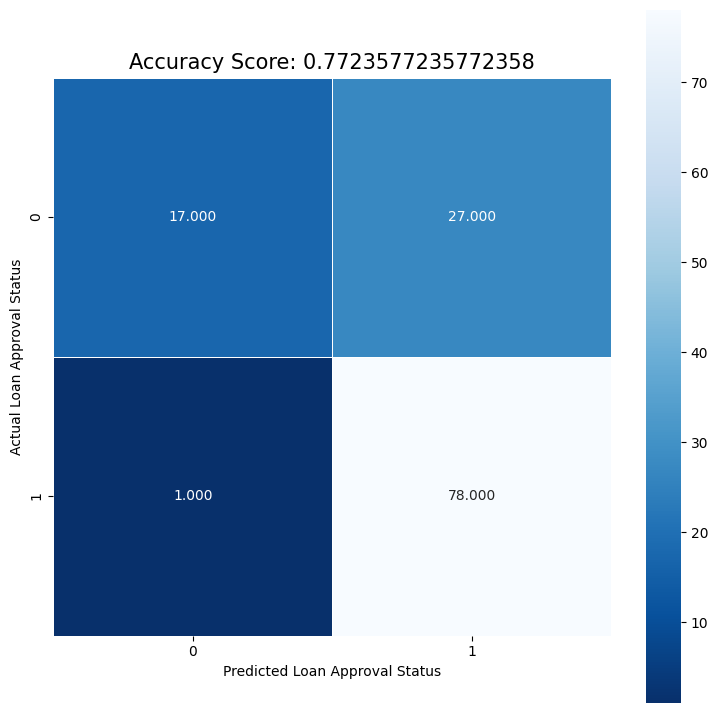

In [14]:
# Calculate and plot the confusion matrix

confusion_matrix = metrics.confusion_matrix(test_y, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual Loan Approval Status')
plt.xlabel('Predicted Loan Approval Status')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

## KNN (K-nearest Neighbours)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from math import inf

In [16]:
# train the model and compare (try different values for the parameters)

# pick the one with the highest mean of cross validation scores
knn_model = KNeighborsClassifier()
cv_score_mean = 0

for n_neighbors_val in [1, 5, 10, 15]:
  for weights_val in ['distance', 'uniform']:
    for metric_val in ['euclidean', 'manhattan', 'minkowski']:
      for p_val in [1, 2, 3]:
        for leaf_size_val in [5, 10, 20, 30]:
          curr_model = KNeighborsClassifier(
              n_neighbors = n_neighbors_val, 
              weights = weights_val, 
              metric = metric_val, 
              p = p_val,
              leaf_size = leaf_size_val
          )

          curr_model.fit(train_X, train_y)

          curr_score_mean = cross_val_score(curr_model, test_X, test_y, cv=5).mean()

          if (curr_score_mean > cv_score_mean):
            knn_model = curr_model
            cv_score_mean = curr_score_mean

In [17]:
# Test the model

predictions = knn_model.predict(test_X)
score = knn_model.score(test_X, test_y)
print(f"Accuracy = {score}")
print(f"Cross Validation Score Mean = {cv_score_mean}")

Accuracy = 0.5609756097560976
Cross Validation Score Mean = 0.6833333333333333


Text(0.5, 1.0, 'Accuracy Score: 0.5609756097560976')

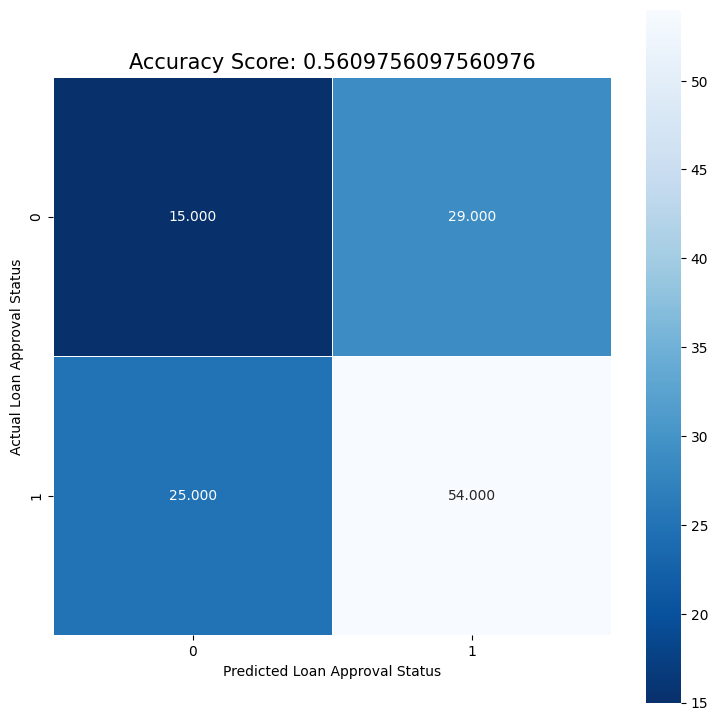

In [18]:
# Calculate and plot the confusion matrix

confusion_matrix = metrics.confusion_matrix(test_y, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual Loan Approval Status')
plt.xlabel('Predicted Loan Approval Status')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

#SVM

In [ ]:
#imports
from sklearn import svm
from sklearn import metrics

In [ ]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
clf.fit(train_X, train_y)
#Predict the response for test dataset
pred_y = clf.predict(test_X)

In [ ]:
print("SVM:")
print("Accuracy:",metrics.accuracy_score(test_y, pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print("Recall:",metrics.recall_score(test_y, pred_y))

SVM:
Accuracy: 0.7886178861788617
Precision: 0.7549019607843137
Recall: 0.9871794871794872


# LDA: Linear Discrimanant Analysis

In [ ]:
#imports
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(train_X,train_y)
pred_y4 = lda.predict(test_X)

In [ ]:
print("LDA")
print("Accuracy:",metrics.accuracy_score(test_y, pred_y4))
print("Precision:",metrics.precision_score(test_y, pred_y4))
print("Recall:",metrics.recall_score(test_y, pred_y4))

LDA
Accuracy: 0.7886178861788617
Precision: 0.7549019607843137
Recall: 0.9871794871794872


# Simple Neural Network

In [ ]:
#imports
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

In [ ]:
nn_train_y = train_y
nn_train_y[nn_train_y == -1]= 0
nn_test_y = test_y
nn_test_y[nn_test_y == -1]= 0

In [ ]:
hidden_units=100
learning_rate=0.01
hidden_layer_act='tanh'
output_layer_act='sigmoid'
no_epochs=100

model = Sequential()
model.add(Dense(hidden_units, input_dim=11, activation=hidden_layer_act))
model.add(Dense(hidden_units, input_dim=11, activation=hidden_layer_act))
model.add(Dense(hidden_units, activation=hidden_layer_act))
model.add(Dense(1, activation=output_layer_act))

In [ ]:
#model = Sequential()
#model.add(Dense(512, activation='relu', input_dim=11))
#model.add(Dense(512, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))


In [ ]:
sgd=optimizers.SGD(lr=learning_rate)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['accuracy'])
model.fit(train_X, nn_train_y, validation_data=(test_X, nn_test_y), epochs=no_epochs, batch_size=len(train_df),  verbose=2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 1s - loss: 0.6142 - accuracy: 0.6925 - val_loss: 0.6708 - val_accuracy: 0.6341 - 920ms/epoch - 920ms/step
Epoch 2/100
1/1 - 0s - loss: 0.6130 - accuracy: 0.6925 - val_loss: 0.6689 - val_accuracy: 0.6341 - 39ms/epoch - 39ms/step
Epoch 3/100
1/1 - 0s - loss: 0.6119 - accuracy: 0.6925 - val_loss: 0.6674 - val_accuracy: 0.6341 - 53ms/epoch - 53ms/step
Epoch 4/100
1/1 - 0s - loss: 0.6110 - accuracy: 0.6925 - val_loss: 0.6665 - val_accuracy: 0.6341 - 36ms/epoch - 36ms/step
Epoch 5/100
1/1 - 0s - loss: 0.6104 - accuracy: 0.6925 - val_loss: 0.6660 - val_accuracy: 0.6341 - 35ms/epoch - 35ms/step
Epoch 6/100
1/1 - 0s - loss: 0.6100 - accuracy: 0.6925 - val_loss: 0.6656 - val_accuracy: 0.6341 - 52ms/epoch - 52ms/step
Epoch 7/100
1/1 - 0s - loss: 0.6097 - accuracy: 0.6925 - val_loss: 0.6652 - val_accuracy: 0.6341 - 61ms/epoch - 61ms/step
Epoch 8/100
1/1 - 0s - loss: 0.6094 - accuracy: 0.6925 - val_loss: 0.6649 - val_accuracy: 0.6341 - 36ms/epoch - 36ms/step
Epoch 9/100
1/1 - 0s - loss: 0.609

In [ ]:
predictions = model.predict(test_X)
rounded = [int(round(x[0])) for x in predictions]


4/4 [==============================] - 0s 3ms/step


In [ ]:
print("Simple NN")
print("Accuracy:",metrics.accuracy_score(nn_test_y, rounded))
print("Precision:",metrics.precision_score(nn_test_y, rounded))
print("Recall:",metrics.recall_score(nn_test_y, rounded))

Simple NN
Accuracy: 0.6341463414634146
Precision: 0.6363636363636364
Recall: 0.9871794871794872


Epoch 1/100
1/1 [==============================] - 0s 78ms/step - loss: 0.6165 - accuracy: 0.6843 - val_loss: 0.6122 - val_accuracy: 0.7073
Epoch 2/100
1/1 [==============================] - 0s 44ms/step - loss: 0.6165 - accuracy: 0.6843 - val_loss: 0.6127 - val_accuracy: 0.7073
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 0.6165 - accuracy: 0.6843 - val_loss: 0.6121 - val_accuracy: 0.7073
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 0.6164 - accuracy: 0.6843 - val_loss: 0.6126 - val_accuracy: 0.7073
Epoch 5/100
1/1 [==============================] - 0s 37ms/step - loss: 0.6164 - accuracy: 0.6843 - val_loss: 0.6120 - val_accuracy: 0.7073
Epoch 6/100
1/1 [==============================] - 0s 37ms/step - loss: 0.6164 - accuracy: 0.6843 - val_loss: 0.6125 - val_accuracy: 0.7073
Epoch 7/100
1/1 [==============================] - 0s 51ms/step - loss: 0.6164 - accuracy: 0.6843 - val_loss: 0.6119 - val_accuracy: 0.7073
Epoch 8/100
1/1 [===

[]

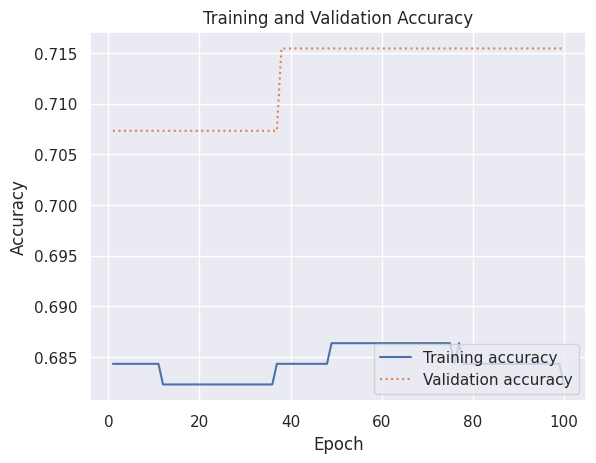

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
hist = model.fit(train_X, nn_train_y, validation_data=(test_X, nn_test_y), epochs=no_epochs, batch_size=len(train_df),  verbose=1)
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

4/4 [==============================] - 0s 3ms/step


Text(109.44999999999997, 0.5, 'Actual label')

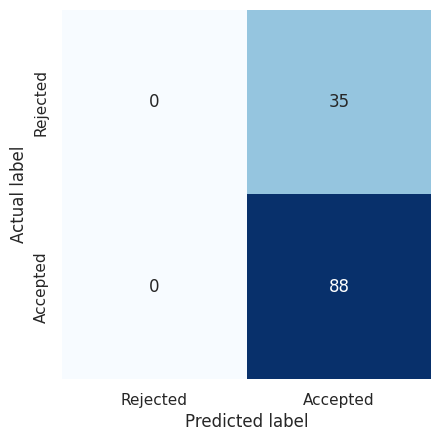

In [ ]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model.predict(test_X) > 0.5
mat = confusion_matrix(nn_test_y, y_predicted)
labels = ['Rejected', 'Accepted']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

# Ridge Regression


In [ ]:
from sklearn.linear_model import RidgeClassifier


rdgclassifier = RidgeClassifier()
rdgclassifier.fit(train_X, train_y)
pred_y2 = rdgclassifier.predict(test_X)
print("Ridge:")
print("Accuracy:",metrics.accuracy_score(test_y, pred_y2))
print("Precision:",metrics.precision_score(test_y, pred_y2))
print("Recall:",metrics.recall_score(test_y, pred_y2))

Ridge:
Accuracy: 0.7886178861788617
Precision: 0.7549019607843137
Recall: 0.9871794871794872


#Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtr = DecisionTreeClassifier(criterion="entropy")
dtr = dtr.fit(train_X,train_y)
pred_y = dtr.predict(test_X)
print("Decision Tree:")
print("Accuracy:",metrics.accuracy_score(test_y, pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print("Recall:",metrics.recall_score(test_y, pred_y))

Decision Tree:
Accuracy: 0.7479674796747967
Precision: 0.7831325301204819
Recall: 0.8333333333333334


In [ ]:
!pip install six

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


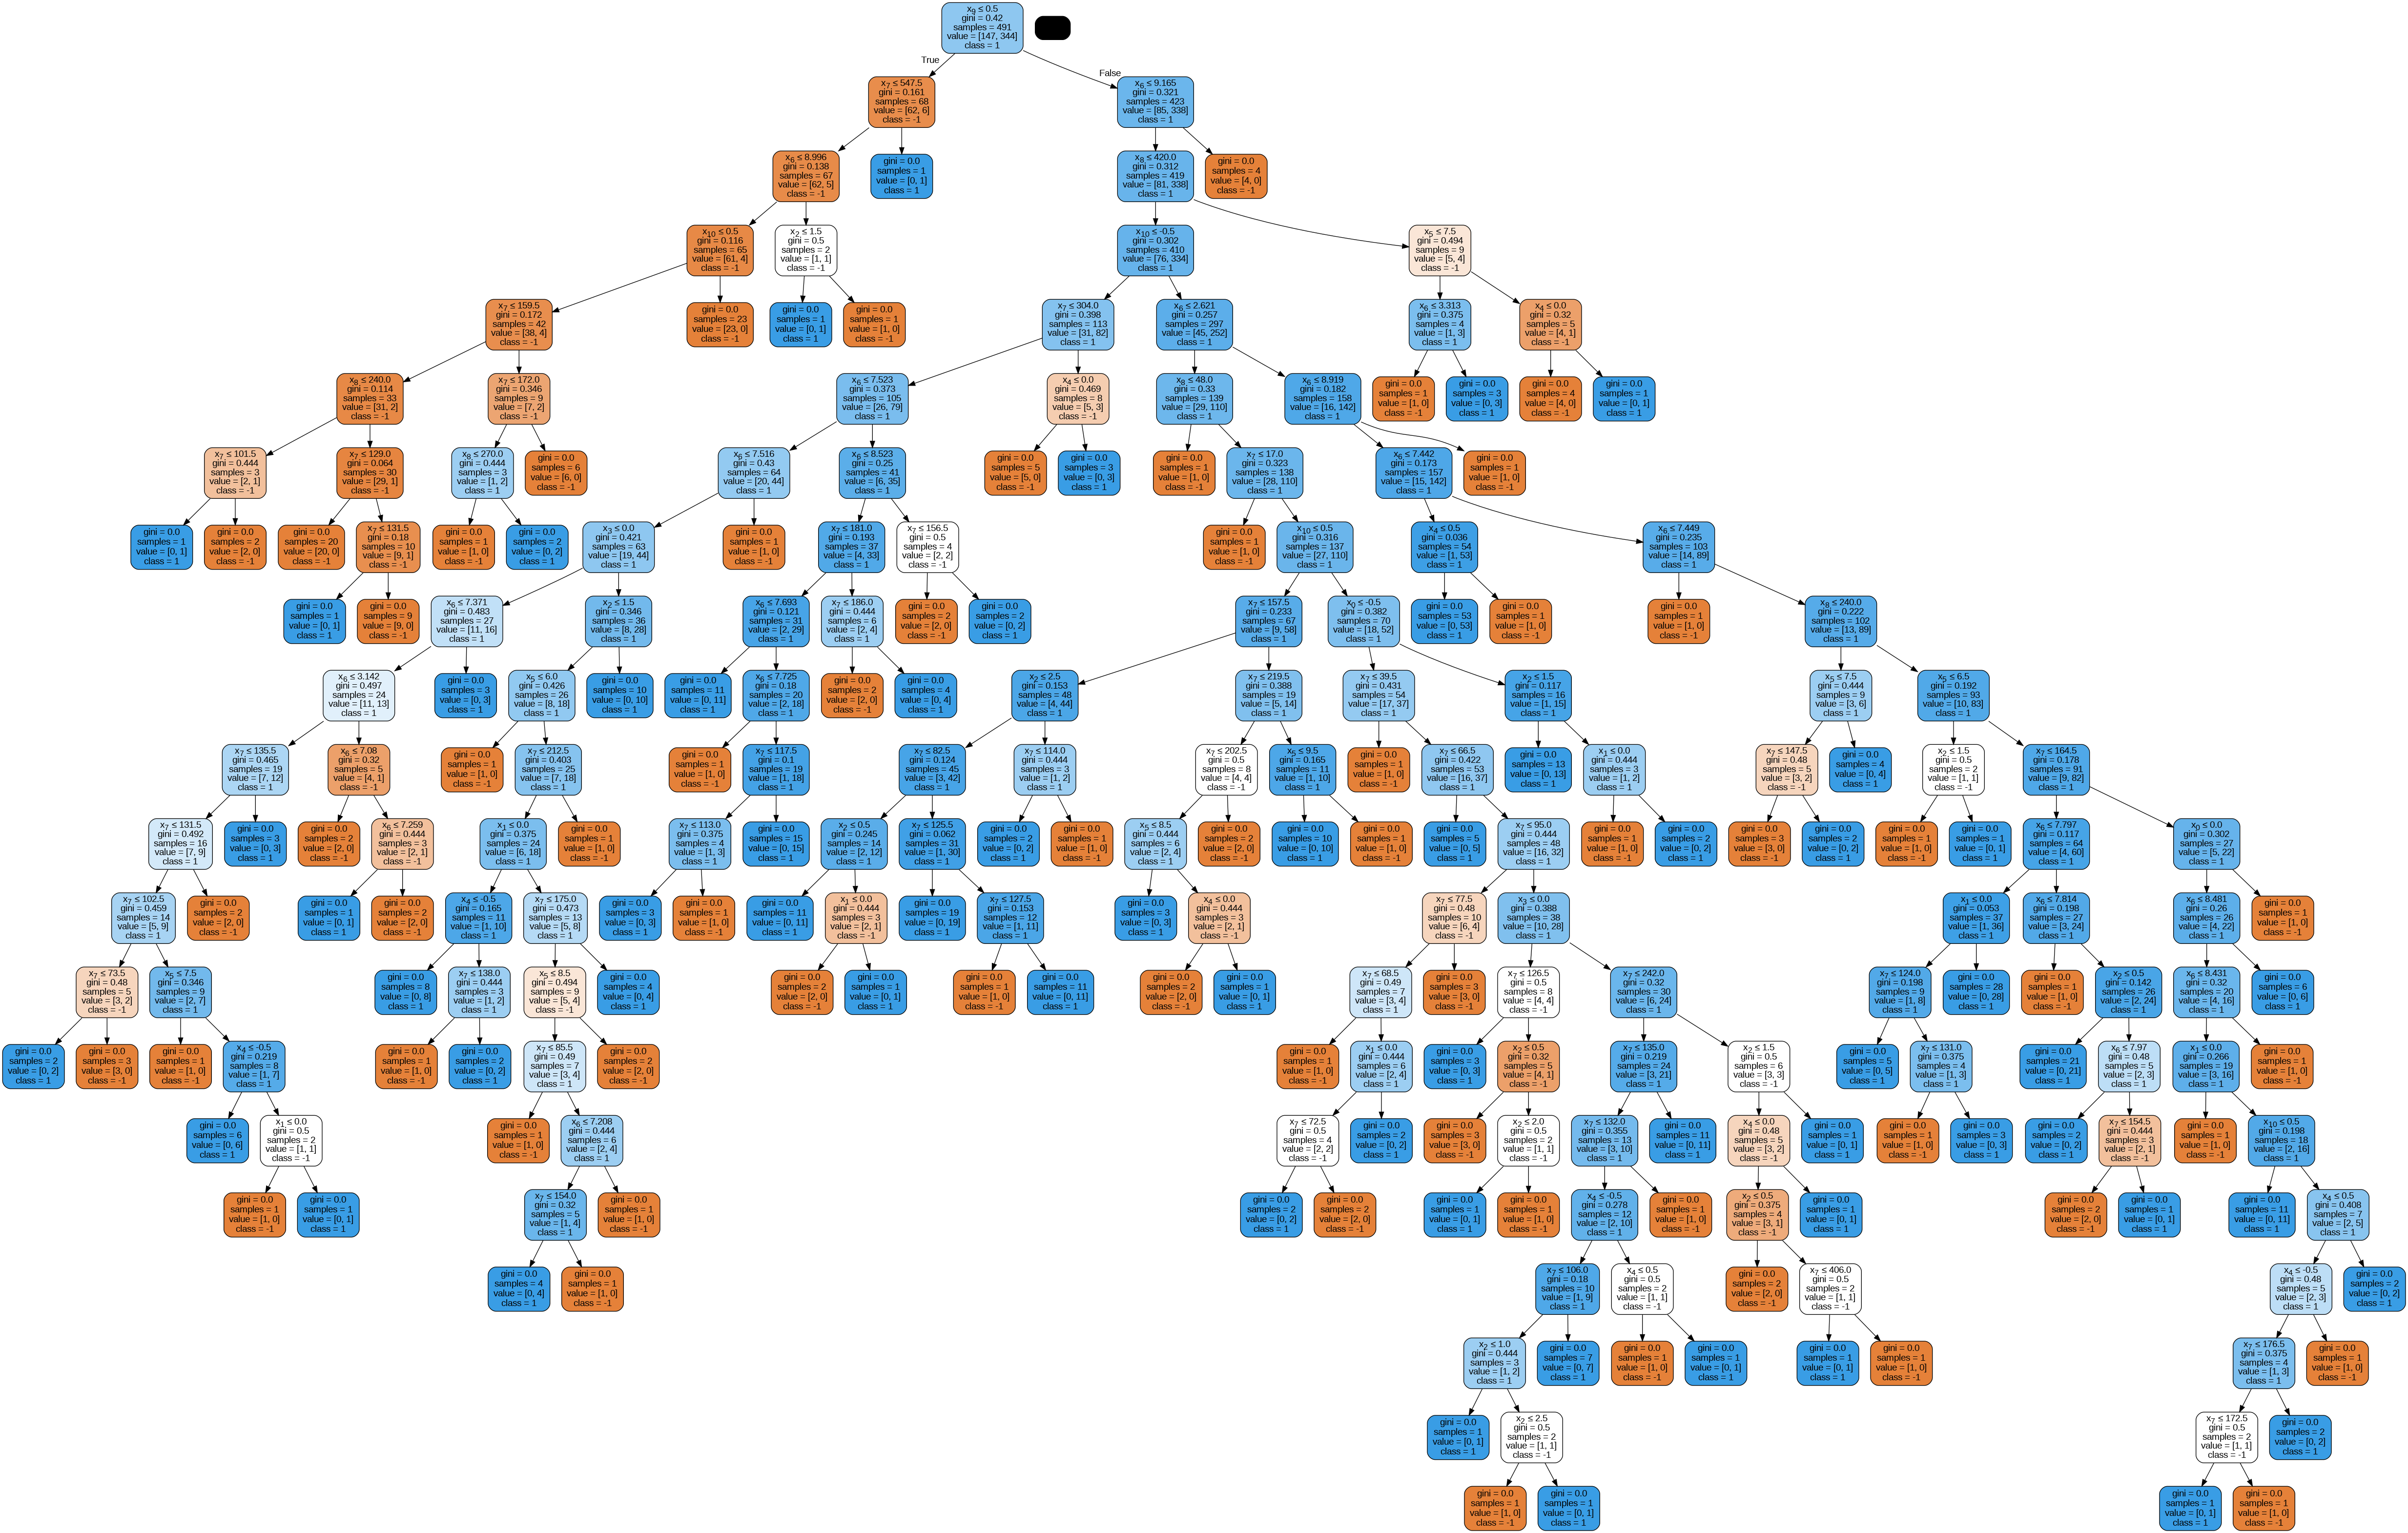

In [ ]:


from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(dtr, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=['-1','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

Decision Tree:
Accuracy: 0.7804878048780488
Precision: 0.7524752475247525
Recall: 0.9743589743589743


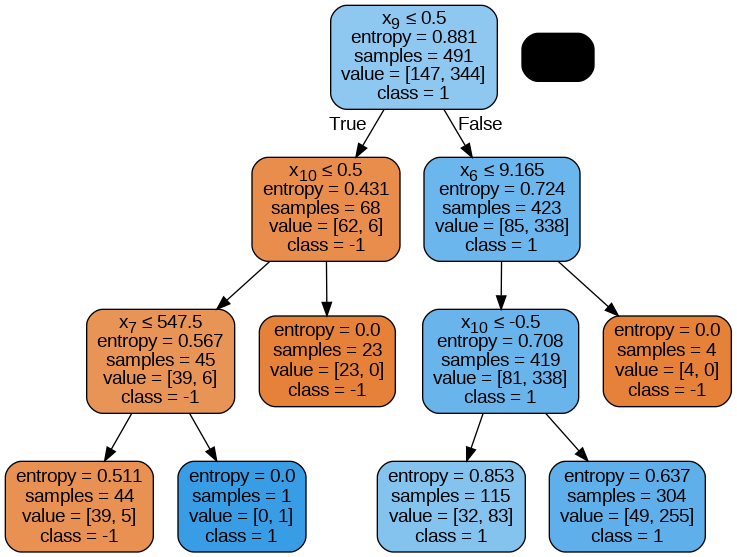

In [ ]:
dtr = DecisionTreeClassifier(criterion="entropy", max_depth=3)
dtr = dtr.fit(train_X,train_y)
pred_y = dtr.predict(test_X)
print("Decision Tree:")
print("Accuracy:",metrics.accuracy_score(test_y, pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print("Recall:",metrics.recall_score(test_y, pred_y))

dot_data = StringIO()
export_graphviz(dtr, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=['-1','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 420)
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)
#rounding predicted values
pred_y[pred_y <0] = -1
pred_y[pred_y >=0] = 1
print("Random Forest:")
print("Accuracy:",metrics.accuracy_score(test_y, pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print("Recall:",metrics.recall_score(test_y, pred_y))

Random Forest:
Accuracy: 0.7804878048780488
Precision: 0.7575757575757576
Recall: 0.9615384615384616
